In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import re 
from pathlib import Path
import tarfile 
import urllib.request
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


In [4]:
def download_titanic_dataset():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://homl.info/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")

def read_dataset(dataset_type):
    return pd.read_csv(f'datasets/titanic/{dataset_type}.csv')

def categorical_count(data, cat_col):
    sns.countplot(x=data[cat_col])
    plt.show()
    
    cat_col_count = data[cat_col].value_counts().to_frame(name='count').reset_index()
    cat_col_count['percent'] = round((cat_col_count['count'] / cat_col_count['count'].sum()) * 100,2)
    cat_col_count.sort_values(cat_col)
    return cat_col_count

def feature_survival(data, col):
    data_count = data.groupby([col, 'survived']).count()['passengerid'].to_frame(name='count').reset_index()
    data_count['percent'] = round((data_count['count'] / data_count['count'].sum()) * 100,2)
    sns.barplot(x=data_count[col], y=data_count['percent'], hue=data_count['survived'])
    plt.show()
    return data_count

##### Ingest and Inspect Data Types/Statistics

In [5]:
# download titanic dataset
download_titanic_dataset()

# read train and test datasets into dataframe
train_df = read_dataset('train')
test_df = read_dataset('test')

# create copy of training dataset 
titanic = train_df.copy()

In [6]:
# lower case column names
titanic.columns = titanic.columns.str.lower()

# inspect first 5 rows
titanic.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# print train dataset info 
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
# missing value percentage
missing_cols = ['age', 'cabin', 'embarked']

for col in missing_cols:
    print(f"{col}: {round(titanic[col].isna().sum() / len(titanic) * 100, 2)} %")

age: 19.87 %
cabin: 77.1 %
embarked: 0.22 %


In [9]:
# summary statistics on titanic dataset
titanic.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Exploratory Data Analysis

#### A. Univariate Analysis - Categorical Data

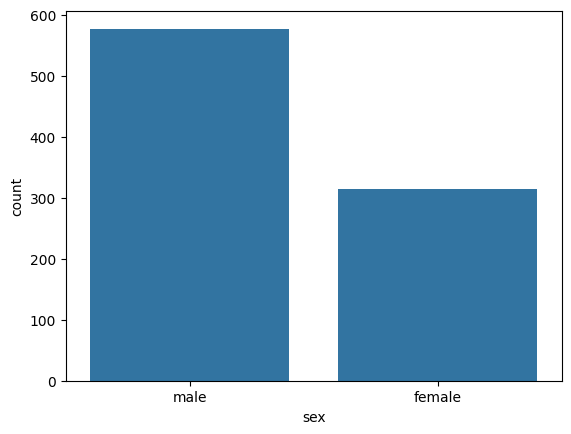

,sex,count,percent
0,male,577,64.76
1,female,314,35.24


In [10]:
categorical_count(titanic, 'sex')

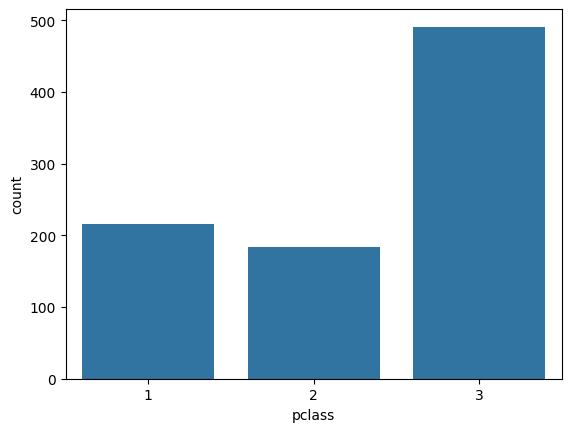

,pclass,count,percent
0,3,491,55.11
1,1,216,24.24
2,2,184,20.65


In [11]:
categorical_count(titanic, 'pclass')

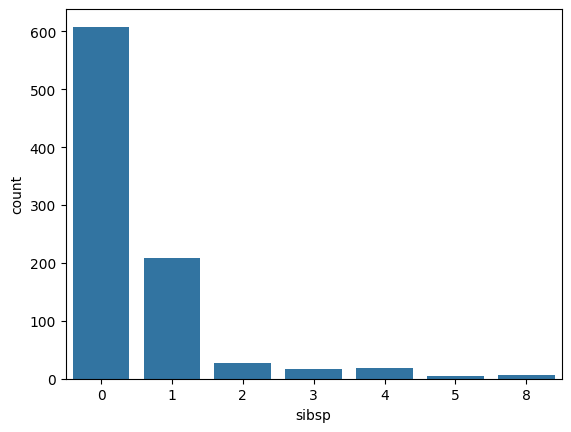

,sibsp,count,percent
0,0,608,68.24
1,1,209,23.46
2,2,28,3.14
3,4,18,2.02
4,3,16,1.80
5,8,7,0.79
6,5,5,0.56


In [12]:
categorical_count(titanic, 'sibsp')

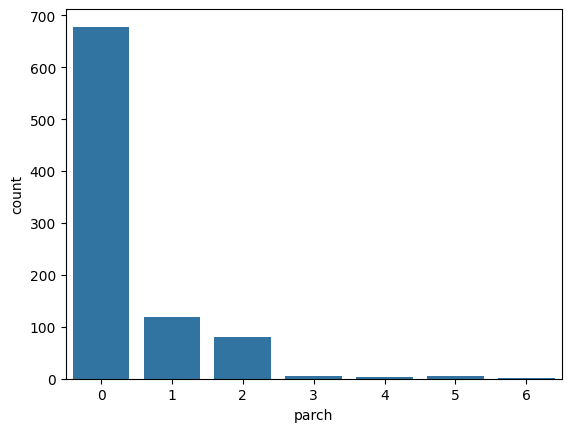

,parch,count,percent
0,0,678,76.09
1,1,118,13.24
2,2,80,8.98
3,5,5,0.56
4,3,5,0.56
5,4,4,0.45
6,6,1,0.11


In [22]:
categorical_count(titanic, 'parch')

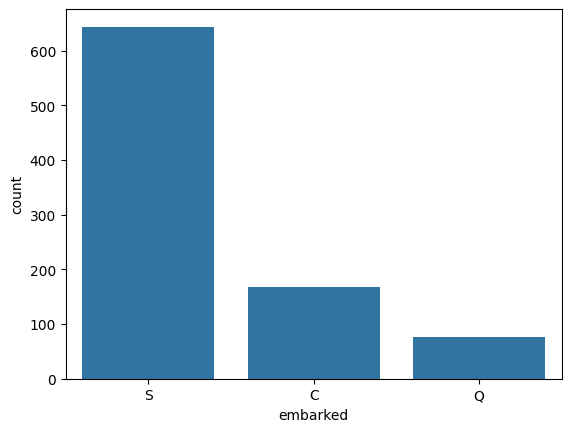

,embarked,count,percent
0,S,644,72.44
1,C,168,18.90
2,Q,77,8.66


In [20]:
categorical_count(titanic, 'embarked')

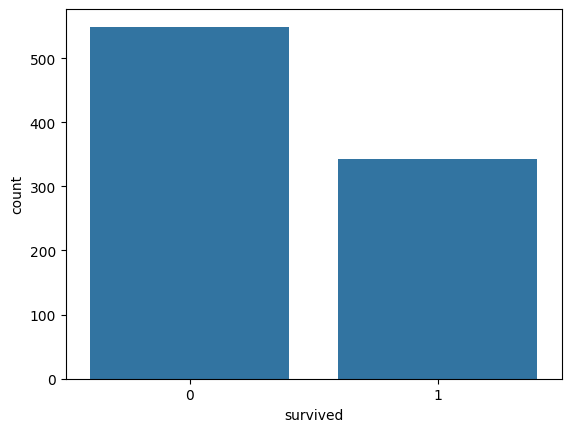

,survived,count,percent
0,0,549,61.62
1,1,342,38.38


In [13]:
categorical_count(titanic, 'survived')

#### B. Univariate Analysis - Numerical Data

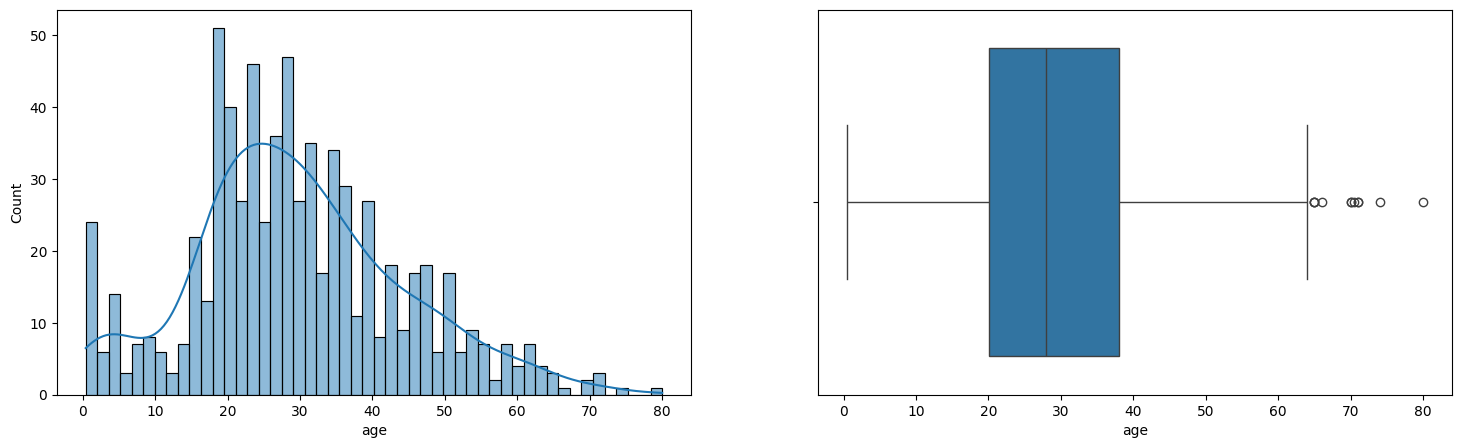

In [15]:
# Age Distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

for i, col in enumerate(titanic.columns):
    if col == 'age':
        sns.histplot(titanic[col], bins=50, kde=True, ax=axes[0])
        sns.boxplot(x=titanic[col])

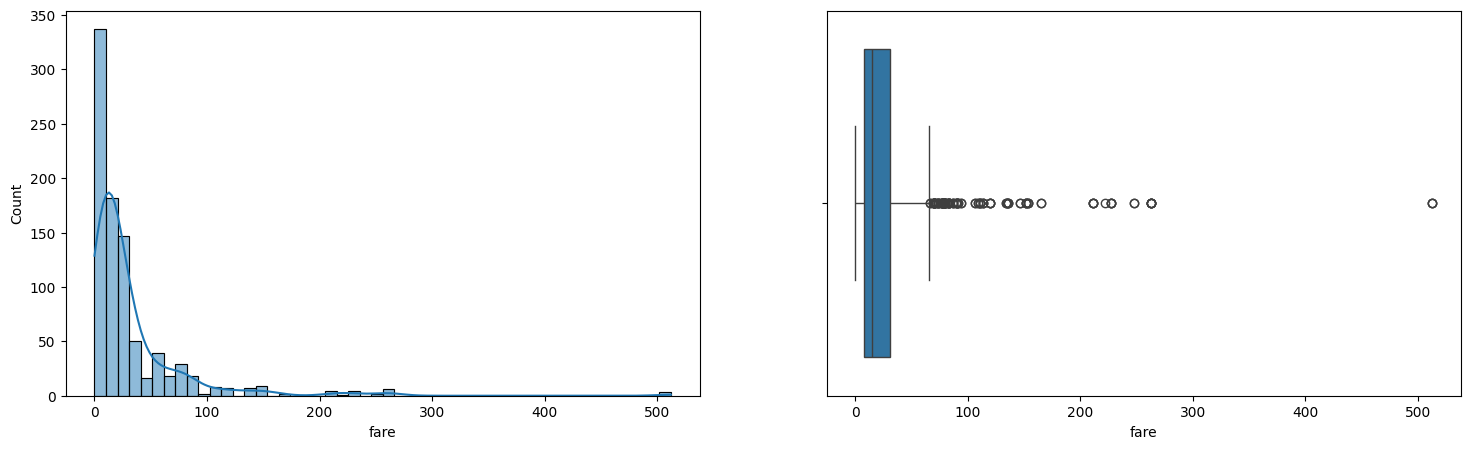

In [14]:
# Age Distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

for i, col in enumerate(titanic.columns):
    if col == 'fare':
        sns.histplot(titanic[col], bins=50, kde=True, ax=axes[0])
        sns.boxplot(x=titanic[col])

#### C. Multivariate Analysis

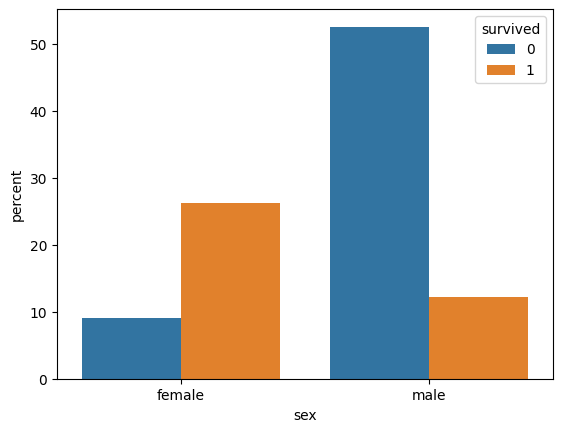

In [16]:
## Plot features against target variable
sex_survival = feature_survival(titanic, 'sex')

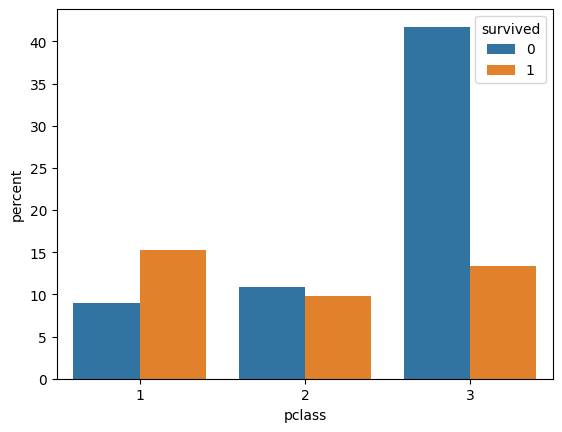

In [17]:
pclass_survival = feature_survival(titanic, 'pclass')

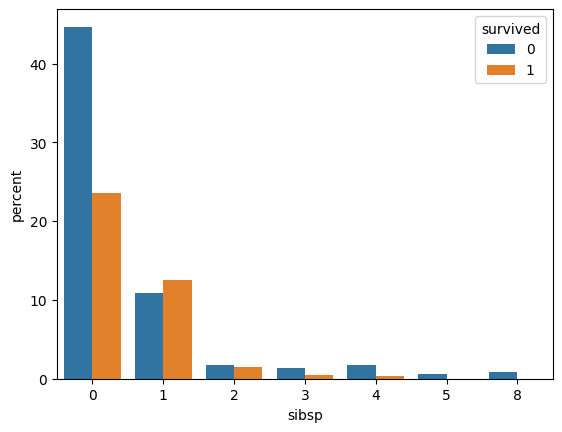

In [18]:
sibsp_survival = feature_survival(titanic, 'sibsp')

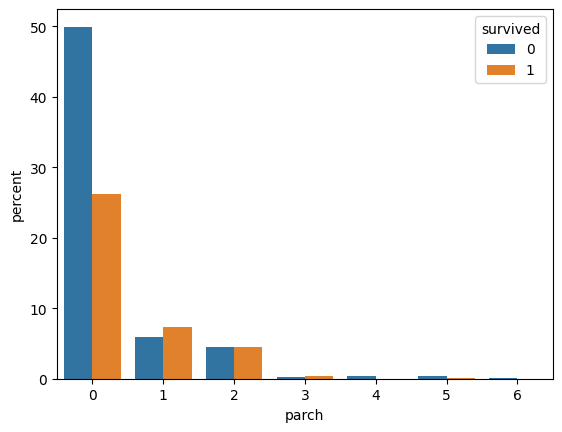

In [21]:
parch_survival = feature_survival(titanic, 'parch')

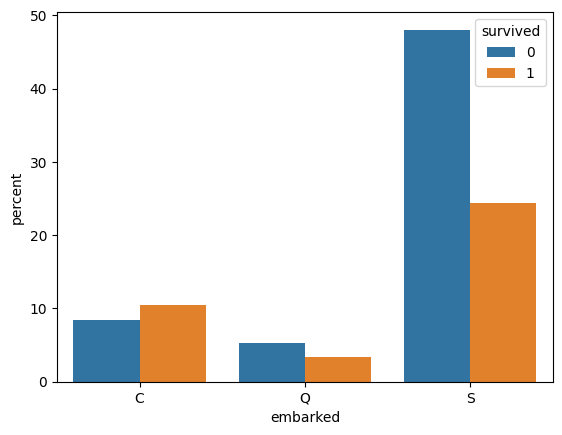

In [19]:
embarked_survival = feature_survival(titanic, 'embarked')

<Axes: >

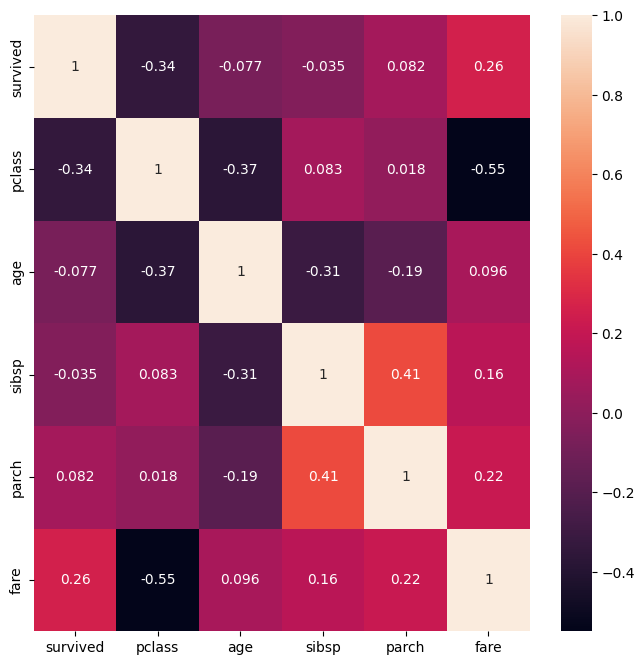

In [23]:
plt.figure(figsize=(8,8))
sns.heatmap(titanic.drop(columns=['name', 'sex', 'ticket', 'cabin', 'passengerid', 'embarked']).corr(), annot=True)


<Axes: xlabel='age', ylabel='Count'>

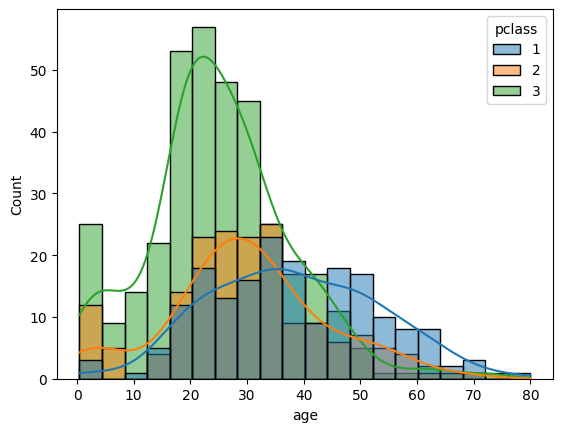

In [38]:
titanic['pclass'] = titanic['pclass'].astype('category')
sns.histplot(data=titanic, x='age', hue='pclass', kde=True)

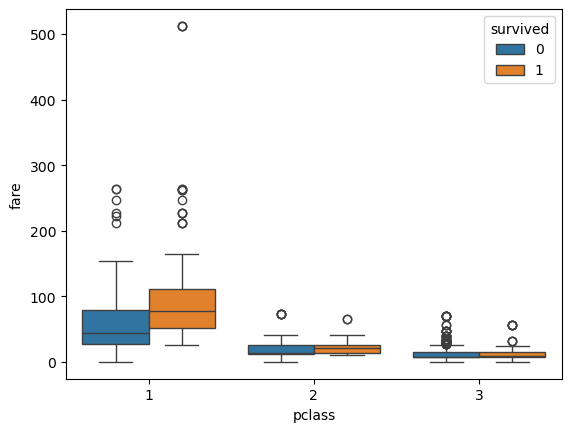

In [304]:
# Exploring fare and pclass relationship
sns.boxplot(x=titanic['pclass'], y=titanic['fare'], hue=titanic['survived'])
plt.show()

In [305]:
# extract title from name
titanic['title'] = titanic.name.str.split('.', expand=True)[0].str.split(',',expand=True)[1].str.replace(' ', '')
titanic['title'] = titanic.title.str.replace('Mme', 'Mrs')
titanic['title'] = titanic.title.str.replace('Mlle', 'Miss')
titanic['title'] = titanic.title.str.replace('Ms', 'Miss')
titanic['title'] = np.where((titanic['title'] == 'Jonkheer') | 
                                (titanic['title'] == 'theCountess') | 
                                    (titanic['title'] == 'Col') | 
                                        (titanic['title'] == 'Capt') | 
                                            (titanic['title'] == 'Don') | 
                                                (titanic['title'] == 'Dr') | 
                                                    (titanic['title'] == 'Master') | 
                                                        (titanic['title'] == 'Rev') | 
                                                            (titanic['title'] == 'Major') | 
                                                                (titanic['title'] == 'Sir') | 
                                                                    (titanic['title'] == 'Lady'), 'Other', titanic['title'])

In [306]:
# drop passenger id and cabin columns
clean_titanic = titanic.drop(columns=['passengerid', 'cabin', 'ticket', 'name'])

In [307]:
clean_titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Other
887,1,1,female,19.0,0,0,30.0000,S,Miss
888,0,3,female,NaN,1,2,23.4500,S,Miss
889,1,1,male,26.0,0,0,30.0000,C,Mr


#### Data Preprocessing

In [308]:
# Data preprocessing functions
# Custom transformer to cast to int and retain feature names
class AgeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.astype(int)
    
    def get_feature_names_out(self, input_features=None):
        return input_features

def age_pipeline():
    return make_pipeline(SimpleImputer(strategy='mean'), AgeTransformer(), StandardScaler())

def embarked_pipeline():
    return make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='if_binary'))

def add_travellers(data):
    return np.sum(data, axis=1).to_numpy().reshape(-1, 1)

def traveller_name(function_transformer, feature_names_in):
    return ["group_size"]

# Correct the group_travel_pipeline
def group_travel_pipeline():
    return make_pipeline(FunctionTransformer(add_travellers, feature_names_out=traveller_name), StandardScaler())

def fare_pipeline():
    return make_pipeline(FunctionTransformer(np.log1p, feature_names_out="one-to-one"), StandardScaler())

# Create the ColumnTransformer
test_preprocessing = ColumnTransformer(
    [
        ("age", age_pipeline(), ["age"]),  
        ("embarked", embarked_pipeline(), ["embarked"]),  
        ("pclass", OrdinalEncoder(), ["pclass"]), 
        ("fare", fare_pipeline(), ["fare"]),
        ("sex", OneHotEncoder(drop='if_binary'), ["sex"]), 
        ("title", OneHotEncoder(), ["title"]), 
        ("group_travel", group_travel_pipeline(), ["sibsp", "parch"])
    ],
    remainder='drop', verbose_feature_names_out=False
)

# Custom transformer for final processing in the pipeline
class FinaliseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, test_preprocessing):
        self.test_preprocessing = test_preprocessing

    def fit(self, X, y=None):
        # Fit the preprocessing pipeline on the data
        self.test_preprocessing.fit(X, y)
        return self

    def transform(self, X):
        # Apply the transformations
        transformed_data = self.test_preprocessing.transform(X)
        
        # Get the feature names after transformation
        feature_names = self.test_preprocessing.get_feature_names_out()
        
        # Convert to DataFrame and assign feature names
        transformed_df = pd.DataFrame(transformed_data, columns=feature_names)
        
        return transformed_df

#### Model Selection

##### A. Logistic Regression

In [309]:
# Logistic Regression is assumed to be the baseline
from sklearn.linear_model import LogisticRegression

y_train = titanic['survived']

In [310]:
# Conduct Grid Search for Logistic Regression
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("finalise", FinaliseTransformer(test_preprocessing)), 
    ("regression", LogisticRegression(random_state=42))
])

# Define the parameter grid
params_grid = [
    {'regression__penalty' : ['l1', 'l2'],
     'regression__solver' : ['liblinear'],  # liblinear works with l1 and l2
     'regression__C' : [0.1, 1, 10]
    }
]

# Conduct Grid Search
lr_gridsearch = GridSearchCV(full_pipeline, params_grid, cv=5, scoring="f1")
lr_gridsearch.fit(clean_titanic, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('finalise',
                                        FinaliseTransformer(test_preprocessing=ColumnTransformer(transformers=[('age',
                                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                                 SimpleImputer()),
                                                                                                                                ('agetransformer',
                                                                                                                                 AgeTransformer()),
                                                                                                                                ('standardscaler',
                                                                                                                                 StandardScaler())]),
                                                                                                                ['age']),
                                                                                                               ('embarked',
                                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                                 SimpleImputer(strategy='most_frequent'...
                                                                                                                                 FunctionTransformer(feature_names_out=<function traveller_name at 0x17c462200>,
                                                                                                                                                     func=<function add_travellers at 0x17b9516c0>)),
                                                                                                                                ('standardscaler',
                                                                                                                                 StandardScaler())]),
                                                                                                                ['sibsp',
                                                                                                                 'parch'])],
                                                                                                 verbose_feature_names_out=False))),
                                       ('regression',
                                        LogisticRegression(random_state=42))]),
             param_grid=[{'regression__C': [0.1, 1, 10],
                          'regression__penalty': ['l1', 'l2'],
                          'regression__solver': ['liblinear']}],
             scoring='f1')

In [311]:
# Cross validation results of grid search
lr_cvresults = pd.DataFrame(lr_gridsearch.cv_results_)
lr_cvresults.sort_values(by="mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regression__C,param_regression__penalty,param_regression__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.013967,0.000235,0.005349,0.000060,1.0,l2,liblinear,"{'regression__C': 1, 'regression__penalty': 'l...",0.751773,0.751880,0.715328,0.764228,0.781955,0.753033,0.021846,1
1,0.014976,0.001120,0.005492,0.000325,0.1,l2,liblinear,"{'regression__C': 0.1, 'regression__penalty': ...",0.750000,0.769231,0.720588,0.754098,0.765625,0.751908,0.017191,2
4,0.035069,0.003905,0.005437,0.000056,10.0,l1,liblinear,"{'regression__C': 10, 'regression__penalty': '...",0.751773,0.746269,0.729927,0.731707,0.776119,0.747159,0.016712,3
5,0.014071,0.000127,0.005429,0.000113,10.0,l2,liblinear,"{'regression__C': 10, 'regression__penalty': '...",0.751773,0.746269,0.729927,0.731707,0.776119,0.747159,0.016712,3
2,0.020043,0.002035,0.005483,0.000209,1.0,l1,liblinear,"{'regression__C': 1, 'regression__penalty': 'l...",0.751773,0.742424,0.715328,0.747967,0.772727,0.746044,0.018467,5
0,0.023917,0.004007,0.007001,0.001188,0.1,l1,liblinear,"{'regression__C': 0.1, 'regression__penalty': ...",0.703125,0.746269,0.725926,0.747967,0.748092,0.734276,0.017676,6


#### Evaluating Logistic Regression Results 

In [312]:
def print_evaluation_results(model):
    test_model = make_pipeline(FinaliseTransformer(test_preprocessing), model)
    cross_y_pred = cross_val_predict(test_model, clean_titanic, y_train, cv=5)
    cm = confusion_matrix(y_train, cross_y_pred)

    # Plotting the confusion matrix using Seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    # Add labels and title
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

    # Calculate evaluation metrics
    precision_lr = precision_score(y_train, cross_y_pred)
    recall_lr = recall_score(y_train, cross_y_pred)
    f1_score_lr = f1_score(y_train, cross_y_pred)
    
    print('Metrics: ')
    print('Precision: ', precision_lr)
    print('Recall: ', recall_lr)
    print('F1 score: ', f1_score_lr)


def plot_precision_recall():

    plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

    plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

    # extra code – just beautifies and saves Figure 3–6
    plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
    plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    plt.grid()
    plt.legend(loc="lower left")

    plt.show()
        

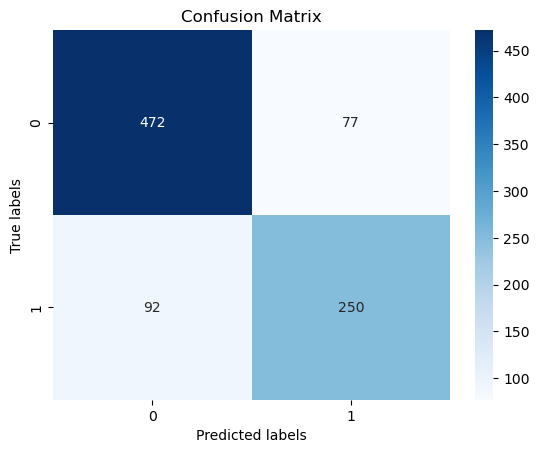

Metrics: 
Precision:  0.764525993883792
Recall:  0.7309941520467836
F1 score:  0.7473841554559043


In [313]:
print_evaluation_results(LogisticRegression(penalty='l1', C=10, random_state=42, solver='liblinear'))

##### B. SGD Classifier

In [314]:
from sklearn.linear_model import SGDClassifier

full_pipeline2 = Pipeline([
    ("finalise", FinaliseTransformer(test_preprocessing)), 
    ("classifier", SGDClassifier(random_state=42))
])

# Define the parameter grid
params_grid2 = [
    {'classifier__loss' : ['perceptron', 'hinge', 'log_loss'],
     'classifier__penalty' : ['l1', 'l2', None],  # liblinear works with l1 and l2
     'classifier__early_stopping' : [True, False]
    }
]

# Conduct Grid Search
sgd_gridsearch = GridSearchCV(full_pipeline2, params_grid2, cv=5, scoring="f1")
sgd_gridsearch.fit(clean_titanic, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('finalise',
                                        FinaliseTransformer(test_preprocessing=ColumnTransformer(transformers=[('age',
                                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                                 SimpleImputer()),
                                                                                                                                ('agetransformer',
                                                                                                                                 AgeTransformer()),
                                                                                                                                ('standardscaler',
                                                                                                                                 StandardScaler())]),
                                                                                                                ['age']),
                                                                                                               ('embarked',
                                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                                 SimpleImputer(strategy='most_frequent'...
                                                                                                                                 FunctionTransformer(feature_names_out=<function traveller_name at 0x17c462200>,
                                                                                                                                                     func=<function add_travellers at 0x17b9516c0>)),
                                                                                                                                ('standardscaler',
                                                                                                                                 StandardScaler())]),
                                                                                                                ['sibsp',
                                                                                                                 'parch'])],
                                                                                                 verbose_feature_names_out=False))),
                                       ('classifier',
                                        SGDClassifier(random_state=42))]),
             param_grid=[{'classifier__early_stopping': [True, False],
                          'classifier__loss': ['perceptron', 'hinge',
                                               'log_loss'],
                          'classifier__penalty': ['l1', 'l2', None]}],
             scoring='f1')

In [315]:
# Cross validation results of grid search
sgd_cvresults = pd.DataFrame(sgd_gridsearch.cv_results_)
sgd_cvresults.sort_values(by="mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__early_stopping,param_classifier__loss,param_classifier__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,0.016770,0.000646,0.005409,0.000106,False,log_loss,None,"{'classifier__early_stopping': False, 'classif...",0.746667,0.733333,0.702703,0.687023,0.776119,0.729169,0.031637,1
16,0.016735,0.000710,0.005337,0.000064,False,log_loss,l2,"{'classifier__early_stopping': False, 'classif...",0.746667,0.733333,0.702703,0.687023,0.776119,0.729169,0.031637,1
8,0.016699,0.000969,0.005582,0.000287,True,log_loss,None,"{'classifier__early_stopping': True, 'classifi...",0.704000,0.706587,0.718750,0.744526,0.746269,0.724026,0.018155,3
2,0.015608,0.000255,0.005482,0.000048,True,perceptron,None,"{'classifier__early_stopping': True, 'classifi...",0.720000,0.714286,0.742138,0.725926,0.672000,0.714870,0.023368,4
5,0.016993,0.000589,0.006043,0.000464,True,hinge,None,"{'classifier__early_stopping': True, 'classifi...",0.727273,0.712329,0.706667,0.765101,0.656489,0.713571,0.035073,5
14,0.015251,0.000519,0.005306,0.000081,False,hinge,None,"{'classifier__early_stopping': False, 'classif...",0.746835,0.590476,0.736842,0.736842,0.751880,0.712575,0.061326,6
13,0.015511,0.000367,0.005327,0.000101,False,hinge,l2,"{'classifier__early_stopping': False, 'classif...",0.736196,0.691729,0.733333,0.732026,0.642202,0.707097,0.036343,7
6,0.016306,0.000480,0.005605,0.000345,True,log_loss,l1,"{'classifier__early_stopping': True, 'classifi...",0.739394,0.736000,0.637681,0.633333,0.714286,0.692139,0.047055,8
10,0.015723,0.000477,0.005616,0.000413,False,perceptron,l2,"{'classifier__early_stopping': False, 'classif...",0.676056,0.621622,0.702290,0.695652,0.751678,0.689460,0.042085,9
12,0.016821,0.000326,0.005779,0.000474,False,hinge,l1,"{'classifier__early_stopping': False, 'classif...",0.579439,0.640449,0.744828,0.609524,0.770270,0.668902,0.075338,10


#### Evaluating SGD Classifier Results 

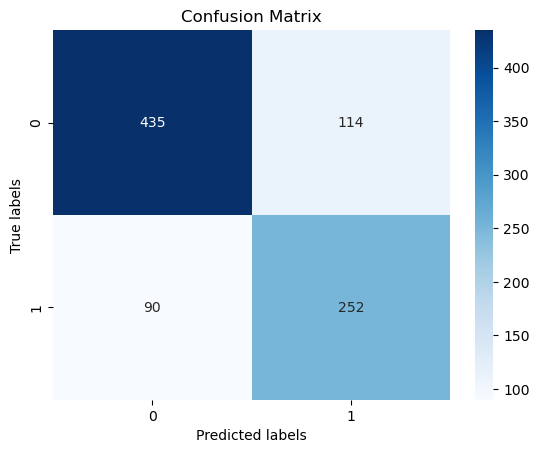

Metrics: 
Precision:  0.6885245901639344
Recall:  0.7368421052631579
F1 score:  0.711864406779661


In [316]:
print_evaluation_results(SGDClassifier(random_state=42))

##### C. DecisionTree Classifier

In [317]:
from sklearn.tree import DecisionTreeClassifier

# Define the pipeline
full_pipeline3 = Pipeline([
    ("finalise", FinaliseTransformer(test_preprocessing)),
    ("decision", DecisionTreeClassifier(random_state=42))
])

# Define the parameter grid
params_grid3 = {
    'decision__criterion': ['log_loss', 'entropy', 'gini'],
    'decision__max_depth': [10,100,None], 
    "decision__min_samples_leaf" : [1, 5, 10, 25, 50, 70],
    "decision__min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35]
}

# Conduct Grid Search
tree_gridsearch = GridSearchCV(full_pipeline3, params_grid3, cv=5, scoring="f1")
tree_gridsearch.fit(clean_titanic, y_train)

# # After fitting, you can access the best parameters and estimator like this:
# best_params = tree_gridsearch.best_params_
# best_estimator = tree_gridsearch.best_estimator_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('finalise',
                                        FinaliseTransformer(test_preprocessing=ColumnTransformer(transformers=[('age',
                                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                                 SimpleImputer()),
                                                                                                                                ('agetransformer',
                                                                                                                                 AgeTransformer()),
                                                                                                                                ('standardscaler',
                                                                                                                                 StandardScaler())]),
                                                                                                                ['age']),
                                                                                                               ('embarked',
                                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                                 SimpleImputer(strategy='most_frequent'...
                                                                                                                                ('standardscaler',
                                                                                                                                 StandardScaler())]),
                                                                                                                ['sibsp',
                                                                                                                 'parch'])],
                                                                                                 verbose_feature_names_out=False))),
                                       ('decision',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'decision__criterion': ['log_loss', 'entropy', 'gini'],
                         'decision__max_depth': [10, 100, None],
                         'decision__min_samples_leaf': [1, 5, 10, 25, 50, 70],
                         'decision__min_samples_split': [2, 4, 10, 12, 16, 18,
                                                         25, 35]},
             scoring='f1')

In [318]:
# Cross validation results of grid search
tree_cvresults = pd.DataFrame(tree_gridsearch.cv_results_)
tree_cvresults.sort_values(by="mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decision__criterion,param_decision__max_depth,param_decision__min_samples_leaf,param_decision__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
158,0.015709,0.000415,0.005978,0.000329,entropy,10,5,25,"{'decision__criterion': 'entropy', 'decision__...",0.779412,0.751880,0.842857,0.694215,0.776119,0.768897,0.047958,1
14,0.014467,0.000147,0.005466,0.000141,log_loss,10,5,25,"{'decision__criterion': 'log_loss', 'decision_...",0.779412,0.751880,0.842857,0.694215,0.776119,0.768897,0.047958,1
101,0.017739,0.000315,0.006607,0.000733,log_loss,None,1,18,"{'decision__criterion': 'log_loss', 'decision_...",0.750000,0.731343,0.839695,0.689076,0.829630,0.767949,0.058026,3
53,0.014703,0.000119,0.005554,0.000184,log_loss,100,1,18,"{'decision__criterion': 'log_loss', 'decision_...",0.750000,0.731343,0.839695,0.689076,0.829630,0.767949,0.058026,3
197,0.014688,0.000130,0.005633,0.000108,entropy,100,1,18,"{'decision__criterion': 'entropy', 'decision__...",0.750000,0.731343,0.839695,0.689076,0.829630,0.767949,0.058026,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,0.013724,0.000128,0.005437,0.000074,gini,100,70,35,"{'decision__criterion': 'gini', 'decision__max...",0.554455,0.687500,0.708661,0.645161,0.781955,0.675547,0.075031,409
382,0.013753,0.000046,0.005409,0.000053,gini,100,70,25,"{'decision__criterion': 'gini', 'decision__max...",0.554455,0.687500,0.708661,0.645161,0.781955,0.675547,0.075031,409
381,0.013828,0.000086,0.005484,0.000072,gini,100,70,18,"{'decision__criterion': 'gini', 'decision__max...",0.554455,0.687500,0.708661,0.645161,0.781955,0.675547,0.075031,409
380,0.013844,0.000103,0.005468,0.000060,gini,100,70,16,"{'decision__criterion': 'gini', 'decision__max...",0.554455,0.687500,0.708661,0.645161,0.781955,0.675547,0.075031,409


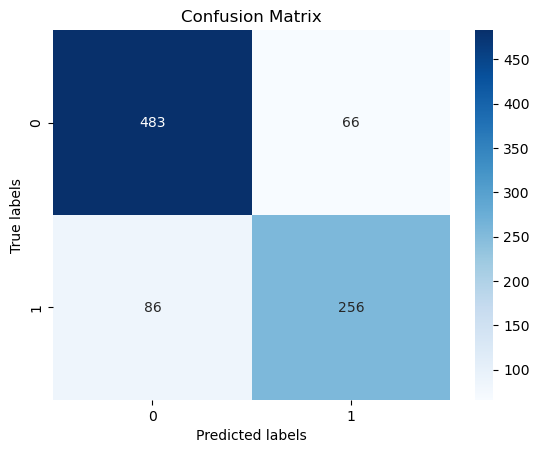

Metrics: 
Precision:  0.7950310559006211
Recall:  0.7485380116959064
F1 score:  0.7710843373493976


In [319]:
print_evaluation_results(DecisionTreeClassifier(random_state=42, criterion='log_loss', max_depth=10, min_samples_leaf=5, min_samples_split=25))

##### D. SVC Classifier

In [320]:
from sklearn.svm import SVC 

full_pipeline4 = Pipeline([
    ("finalise", FinaliseTransformer(test_preprocessing)),
    ("svc", SVC(random_state=42))
])

# Define the parameter grid
params_grid4 = {
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__gamma': ['scale','auto']
}

# Conduct Grid Search
svc_gridsearch = GridSearchCV(full_pipeline4, params_grid4, cv=5, scoring="f1")
svc_gridsearch.fit(clean_titanic, y_train)

# # After fitting, you can access the best parameters and estimator like this:
# best_params = tree_gridsearch.best_params_
# best_estimator = tree_gridsearch.best_estimator_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('finalise',
                                        FinaliseTransformer(test_preprocessing=ColumnTransformer(transformers=[('age',
                                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                                 SimpleImputer()),
                                                                                                                                ('agetransformer',
                                                                                                                                 AgeTransformer()),
                                                                                                                                ('standardscaler',
                                                                                                                                 StandardScaler())]),
                                                                                                                ['age']),
                                                                                                               ('embarked',
                                                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                                                 SimpleImputer(strategy='most_frequent'...
                                                                                                                Pipeline(steps=[('functiontransformer',
                                                                                                                                 FunctionTransformer(feature_names_out=<function traveller_name at 0x17c462200>,
                                                                                                                                                     func=<function add_travellers at 0x17b9516c0>)),
                                                                                                                                ('standardscaler',
                                                                                                                                 StandardScaler())]),
                                                                                                                ['sibsp',
                                                                                                                 'parch'])],
                                                                                                 verbose_feature_names_out=False))),
                                       ('svc', SVC(random_state=42))]),
             param_grid={'svc__gamma': ['scale', 'auto'],
                         'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='f1')

In [321]:
# Cross validation results of grid search
svc_cvresults = pd.DataFrame(svc_gridsearch.cv_results_)
svc_cvresults.sort_values(by="mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__gamma,param_svc__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.037876,0.000944,0.010334,0.000257,scale,poly,"{'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.785185,0.761194,0.757576,0.705882,0.802920,0.762551,0.032802,1
6,0.036336,0.000814,0.012440,0.000307,auto,rbf,"{'svc__gamma': 'auto', 'svc__kernel': 'rbf'}",0.794118,0.761194,0.748092,0.694915,0.805970,0.760858,0.039122,2
5,0.038248,0.000735,0.011145,0.000118,auto,poly,"{'svc__gamma': 'auto', 'svc__kernel': 'poly'}",0.772414,0.746479,0.742857,0.716667,0.820144,0.759712,0.035001,3
2,0.036775,0.000690,0.012458,0.000208,scale,rbf,"{'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.782609,0.761194,0.744186,0.700855,0.805970,0.758963,0.035689,4
0,0.040544,0.002245,0.017261,0.013205,scale,linear,"{'svc__gamma': 'scale', 'svc__kernel': 'linear'}",0.780142,0.750000,0.735294,0.672131,0.759124,0.739338,0.036615,5
4,0.036709,0.001021,0.009826,0.000176,auto,linear,"{'svc__gamma': 'auto', 'svc__kernel': 'linear'}",0.780142,0.750000,0.735294,0.672131,0.759124,0.739338,0.036615,5
7,0.034932,0.000429,0.010448,0.000141,auto,sigmoid,"{'svc__gamma': 'auto', 'svc__kernel': 'sigmoid'}",0.653333,0.633094,0.647482,0.569106,0.631579,0.626919,0.030076,7
3,0.032605,0.000644,0.009598,0.000107,scale,sigmoid,"{'svc__gamma': 'scale', 'svc__kernel': 'sigmoid'}",0.644737,0.552239,0.628571,0.558824,0.656934,0.608261,0.044033,8


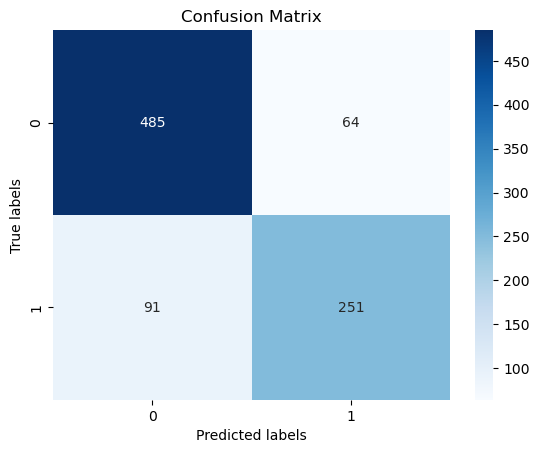

Metrics: 
Precision:  0.7968253968253968
Recall:  0.7339181286549707
F1 score:  0.7640791476407914


In [322]:
print_evaluation_results(SVC(kernel='poly',random_state=42))

- need to plot precision-recall curves between all models to compare which is best. 
- for now, assume decision tree is best since it has highest recall.

#### Predict Test Set

In [323]:
# Define the pipeline
final_pipeline = Pipeline([
    ("finalise", FinaliseTransformer(test_preprocessing)),
    ("decision", DecisionTreeClassifier(random_state=42, criterion='log_loss', max_depth=10, min_samples_leaf=5, min_samples_split=25))
])

final_pipeline.fit(clean_titanic, y_train)


Pipeline(steps=[('finalise',
                 FinaliseTransformer(test_preprocessing=ColumnTransformer(transformers=[('age',
                                                                                         Pipeline(steps=[('simpleimputer',
                                                                                                          SimpleImputer()),
                                                                                                         ('agetransformer',
                                                                                                          AgeTransformer()),
                                                                                                         ('standardscaler',
                                                                                                          StandardScaler())]),
                                                                                         ['age']),
                                                                                        ('embarked',
                                                                                         Pipeline(steps=[('simpleimputer',
                                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                                         ('onehotencoder',
                                                                                                          OneHotEn...
                                                                                         Pipeline(steps=[('functiontransformer',
                                                                                                          FunctionTransformer(feature_names_out=<function traveller_name at 0x17c462200>,
                                                                                                                              func=<function add_travellers at 0x17b9516c0>)),
                                                                                                         ('standardscaler',
                                                                                                          StandardScaler())]),
                                                                                         ['sibsp',
                                                                                          'parch'])],
                                                                          verbose_feature_names_out=False))),
                ('decision',
                 DecisionTreeClassifier(criterion='log_loss', max_depth=10,
                                        min_samples_leaf=5,
                                        min_samples_split=25,
                                        random_state=42))])

In [324]:
test_df.columns = test_df.columns.str.lower()
test_df.drop(columns=['passengerid', 'cabin', 'ticket'])
test_df['title'] = test_df.name.str.split('.', expand=True)[0].str.split(',',expand=True)[1].str.replace(' ', '')
test_df['title'] = test_df.title.str.replace('Mme', 'Mrs')
test_df['title'] = test_df.title.str.replace('Mlle', 'Miss')
test_df['title'] = test_df.title.str.replace('Ms', 'Miss')
test_df['title'] = np.where((test_df['title'] == 'Jonkheer') | 
                                (test_df['title'] == 'theCountess') | 
                                    (test_df['title'] == 'Col') | 
                                        (test_df['title'] == 'Capt') | 
                                            (test_df['title'] == 'Don') | 
                                                (test_df['title'] == 'Dr') | 
                                                    (test_df['title'] == 'Master') | 
                                                        (test_df['title'] == 'Rev') | 
                                                            (test_df['title'] == 'Major') | 
                                                                (test_df['title'] == 'Sir') | 
                                                                    (test_df['title'] == 'Lady') | 
                                                                        (test_df['title'] == 'Dona'), 'Other', test_df['title'])

In [325]:
test_df = test_df.drop(columns=['name', 'ticket', 'cabin'])


In [326]:
finaly_pred = final_pipeline.predict(test_df)

In [336]:
submission = pd.concat([test_df, pd.Series(finaly_pred)], axis=1)

In [337]:
submission = submission[['passengerid', 0]].rename(columns={0 : 'Survived', 'passengerid' : 'PassengerId'})

In [339]:
submission.to_csv('submission.csv', index=False)